In [3]:
!pip install keras==2.4.3

  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
!pip install tensorflow==2.4.1

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

In [2]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import (Dense, Dropout, GlobalMaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import InceptionV3
from keras import optimizers
import tensorflow as tf
import numpy as np
import keras
import time
import random
import json


In [6]:
print("starting")

if __name__ == '__main__':
    start = time.time()
    random.seed(8675309)
    #model = VGG16()
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       rotation_range=5,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       # zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(96, 96),
        subset='training',
        batch_size=64,
        class_mode='categorical'
    )
    val_gen = val_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(96, 96),
        subset='validation',
        batch_size=64,
        class_mode='categorical'
    )
    test_gen = test_datagen.flow_from_directory(
        "/content/archive/test/",
        target_size=(96, 96),
        batch_size=64,
        class_mode='categorical'
    )

    # pre-process the data for Keras
    resnet_model = InceptionV3(weights='imagenet',
                                         include_top=False,
                                         input_shape=(96, 96, 3))

    for layer in resnet_model.layers:
        layer.trainable = False

    # I'll retrain the network from 20th layer
    # for layer in resnet_model.layers[20:]:
    #     layer.trainable = True

    layer_dict = dict([(layer.name, layer) for layer in resnet_model.layers])
    print(layer_dict)

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['mixed7'].output

    x = GlobalMaxPooling2D()(x)

    x = Dense(512, activation='relu')(x)

    x = Dropout(0.5)(x)

    x = Dense(7, activation='softmax')(x)

    model = Model(resnet_model.input, x)

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

    # from keras import optimizers
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=METRICS)
    model.summary()

    jsonmodel = model.to_json()
    with open('expression.json', 'w') as fp:
        json.dump(jsonmodel, fp)

    epochs = 50
    batch_size = 64

    lrd = ReduceLROnPlateau(monitor='val_loss', patience=10,
                            verbose=1, factor=0.50, min_lr=1e-10)

    es = EarlyStopping(verbose=1, patience=10)

    checkpointer = ModelCheckpoint(filepath='expression.hdf5',
                                   verbose=1)

    history = model.fit_generator(train_gen, epochs=epochs, callbacks=[lrd, checkpointer, es],
                                  verbose=1, validation_data=val_gen, validation_steps=5741//batch_size,
                                  steps_per_epoch=22968//batch_size)

    print(history.history.keys())
    
    end = time.time()
    print(end - start)


starting
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{'input_3': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5404b67b90>, 'conv2d_188': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5404c35290>, 'batch_normalization_188': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f5404a10f50>, 'activation_188': <tensorflow.python.keras.layers.core.Activation object at 0x7f5404bac390>, 'conv2d_189': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5466625cd0>, 'batch_normalization_189': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f54047ef550>, 'activation_189': <tensorflow.python.keras.layers.core.Activation object at 0x7f54047ef490>, 'conv2d_190': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5404b4fcd0>, 'batch_normalization_190': <tensorflow.python.keras.layers

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 67s 170ms/step - loss: 2.1252 - accuracy: 0.8375 - precision: 0.2714 - recall: 0.0715 - auc: 0.6316 - val_loss: 1.6419 - val_accuracy: 0.8637 - val_precision: 0.7045 - val_recall: 0.0795 - val_auc: 0.7449

Epoch 00001: saving model to expression.hdf5
Epoch 2/50
358/358 [==============================] - 61s 170ms/step - loss: 1.6908 - accuracy: 0.8597 - precision: 0.5829 - recall: 0.0635 - auc: 0.7254 - val_loss: 1.5856 - val_accuracy: 0.8654 - val_precision: 0.7590 - val_recall: 0.0851 - val_auc: 0.7688

Epoch 00002: saving model to expression.hdf5
Epoch 3/50
358/358 [==============================] - 59s 166ms/step - loss: 1.6328 - accuracy: 0.8629 - precision: 0.6417 - recall: 0.0920 - auc: 0.7485 - val_loss: 1.5589 - val_accuracy: 0.8675 - val_precision: 0.7221 - val_recall: 0.1182 - val_auc: 0.7766

Epoch 00003: saving model to expression.hdf5
Epoch 4/50
358/358 [==============================] - 59s 166ms/step - loss: 1.6169 -

In [7]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

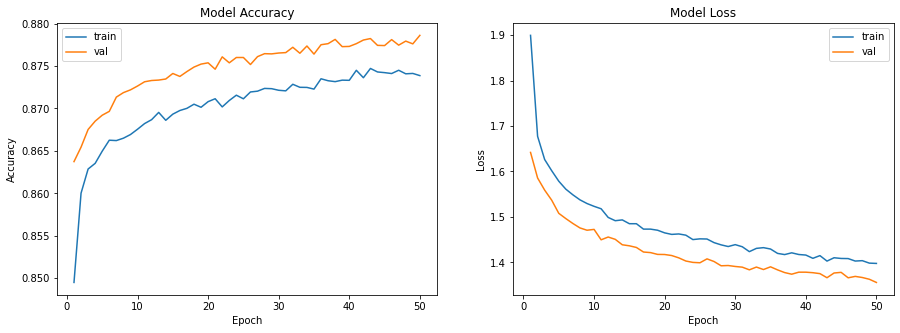

In [8]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

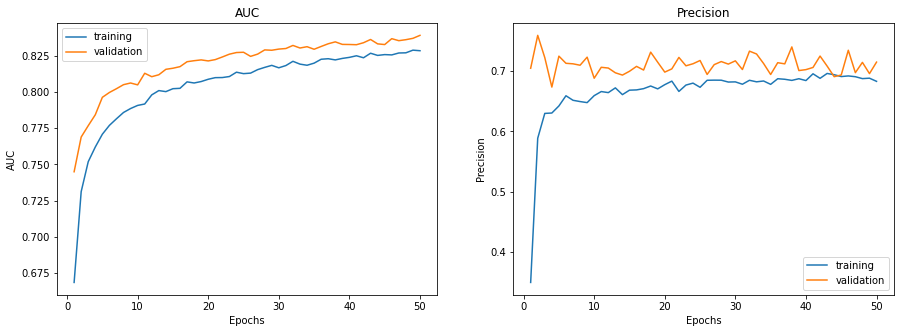

In [9]:
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(range(1, len(auc) + 1), auc)
ax1.plot(range(1, len(val_auc) + 1), val_auc)
ax1.set_title('AUC')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC')
ax1.legend(['training', 'validation'])

ax2.plot(range(1, len(precision) + 1), precision)
ax2.plot(range(1, len(val_precision) + 1), val_precision)
ax2.set_title('Precision')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend(['training', 'validation'])

In [10]:
expression_dict = list(train_gen.class_indices.keys())
expression_dict

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

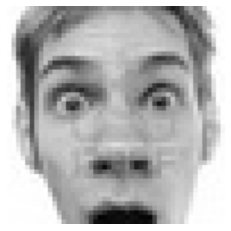

surprise
[[1.0905480e-02 2.2866334e-04 9.2451327e-02 3.4095894e-03 1.0761829e-02
  5.9447060e-03 8.7629837e-01]]


In [12]:
from keras.preprocessing import image

def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(96,96))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


# loaded_model = load_model("model_vgg16.h5")

img_path = '/content/archive/test/surprise/PublicTest_53542593.jpg'

new_image = load_image(img_path)

pred = model.predict(new_image)

predictions = list(pred[0])
expression_output = expression_dict[(predictions.index(max(predictions)))]

print(expression_output)
print(pred)